# 🌎 Welcome to the CSE151B Spring 2025 Climate Emulation Competition!

Thank you for participating in this exciting challenge focused on building machine learning models to emulate complex climate systems.  
This notebook is provided as a **starter template** to help you:

- Understand how to load and preprocess the dataset  
- Construct a baseline model  
- Train and evaluate predictions using a PyTorch Lightning pipeline  
- Format your predictions for submission to the leaderboard  

You're encouraged to:
- Build on this structure or replace it entirely
- Try more advanced models and training strategies
- Incorporate your own ideas to push the boundaries of what's possible

If you're interested in developing within a repository structure and/or use helpful tools like configuration management (based on Hydra) and logging (with Weights & Biases), we recommend checking out the following Github repo. Such a structure can be useful when running multiple experiments and trying various research ideas.

👉 [https://github.com/salvaRC/cse151b-spring2025-competition](https://github.com/salvaRC/cse151b-spring2025-competition)

Good luck, have fun, and we hope you learn a lot through this process!


### 📦 Install Required Libraries
We install the necessary Python packages for data loading, deep learning, and visualization.


In [1]:
import os
from datetime import datetime
import numpy as np
import xarray as xr
import dask.array as da
import math
import torch
import torch.nn as nn
import torch.fft
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
from lightning.pytorch.callbacks import Callback
import zipfile

### ⚙️ Configuration Setup  
Define all model, data, and training hyperparameters in one place for easy control and reproducibility.

### 📊 Data Configuration

We define the dataset settings used for training and evaluation. This includes:

- **`path`**: Path to the `.zarr` dataset containing monthly climate variables from CMIP6 simulations.
- **`input_vars`**: Climate forcing variables (e.g., CO₂, CH₄) used as model inputs.
- **`output_vars`**: Target variables to predict — surface air temperature (`tas`) and precipitation (`pr`).
- **`target_member_id`**: Ensemble member to use from the simulations (each SSP has 3) for target variables.
- **`train_ssps`**: SSP scenarios used for training (low to high emissions).
- **`test_ssp`**: Scenario held out for evaluation (Must be set to SSP245).
- **`test_months`**: Number of months to include in the test split (Must be set to 120).
- **`batch_size`** and **`num_workers`**: Data loading parameters for PyTorch training.

These settings reflect how the challenge is structured: models must learn from some emission scenarios and generalize to unseen ones.

> ⚠️ **Important:** Do **not modify** the following test settings:
>
> - `test_ssp` must remain **`ssp245`**, which is the held-out evaluation scenario.
> - `test_months` must be **`120`**, corresponding to the last 10 years (monthly resolution) of the scenario.



In [2]:
#NOTE Change the data directory according to where you have your zarr files stored
config = {
    "data": {
        "path": "../processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 64,
        "num_workers": 4,
    },
    "model": {
        "type": "simple_cnn",
        "kernel_size": 3,
        "init_dim": 64,
        "depth": 4,
        "dropout_rate": 0.1,
    },
    "training": {
        "lr": 1e-3,
    },
    "trainer": {
        "max_epochs": 40,
        "accelerator": "auto",
        "devices": "auto",
        "precision": 32,
        "deterministic": True,
        "num_sanity_val_steps": 0,
    },
    "seed": 42,
}
pl.seed_everything(config["seed"])  # Set seed for reproducibility

Seed set to 42


42

### 🔧 Spatial Weighting Utility Function

This cell sets up utility functions for reproducibility and spatial weighting:

- **`get_lat_weights(latitude_values)`**: Computes cosine-based area weights for each latitude, accounting for the Earth's curvature. This is critical for evaluating global climate metrics fairly — grid cells near the equator represent larger surface areas than those near the poles.


In [3]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

### 🧠 SimpleCNN: A Residual Convolutional Baseline

This is a lightweight baseline model designed to capture spatial patterns in global climate data using convolutional layers.

- The architecture starts with a **convolution + batch norm + ReLU** block to process the input channels.
- It then applies a series of **residual blocks** to extract increasingly abstract spatial features. These help preserve gradient flow during training.
- Finally, a few convolutional layers reduce the feature maps down to the desired number of output channels (`tas` and `pr`).

This model only serves as a **simple baseline for climate emulation**.

We encourage you to build and experiment with your own models and ideas.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x, pos=None):
        if pos is None:
            return x + self.pe[:, :x.size(1)]
        else:
            return x + self.pe[:, pos]

class TimeEmbedding(nn.Module):
    def __init__(self, time_dim, embedding_dim):
        super().__init__()
        self.month_embed = nn.Embedding(12, embedding_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(embedding_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

    def forward(self, month_idx):
        time_embed = self.month_embed(month_idx)
        time_embed = self.time_mlp(time_embed)
        return time_embed

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=8, attn_dropout=0.0, proj_dropout=0.0):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.0, attn_drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, num_heads=num_heads, attn_dropout=attn_drop, proj_dropout=drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(drop)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class MultiScaleConvStem(nn.Module):
    def __init__(self, in_channels, hidden_dim, patch_size=4):
        super().__init__()
        self.initial_dim = hidden_dim // 4

        self.conv1 = ConvBlock(in_channels, self.initial_dim)

        # Multi-scale pathway 1 (finer details)
        self.pathway1 = nn.Sequential(
            ConvBlock(self.initial_dim, self.initial_dim),
            ConvBlock(self.initial_dim, self.initial_dim)
        )

        # Multi-scale pathway 2 (medium details)
        self.pathway2 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(self.initial_dim, self.initial_dim),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )

        # Multi-scale pathway 3 (larger patterns)
        self.pathway3 = nn.Sequential(
            nn.MaxPool2d(4),
            ConvBlock(self.initial_dim, self.initial_dim),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
        )

        concat_dim = self.initial_dim * 4

        self.fusion = ConvBlock(concat_dim, hidden_dim)
        self.to_tokens = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        features = []

        x0 = self.conv1(x)
        features.append(x0)

        x1 = self.pathway1(x0)
        x2 = self.pathway2(x0)
        x3 = self.pathway3(x0)

        x = torch.cat([x0, x1, x2, x3], dim=1)
        x = self.fusion(x)
        features.append(x)

        tokens = self.to_tokens(x)

        return tokens, features

class DecoderHead(nn.Module):
    def __init__(self, in_channels, hidden_dim, n_output_channels, patch_size=4):
        super().__init__()

        self.upsample = nn.ConvTranspose2d(in_channels, hidden_dim,
                                          kernel_size=patch_size, stride=patch_size)

        self.decode1 = ConvBlock(hidden_dim * 2, hidden_dim)
        self.decode2 = ConvBlock(hidden_dim + hidden_dim // 4, hidden_dim // 2)
        self.final = nn.Conv2d(hidden_dim // 2, n_output_channels, kernel_size=1)

    def forward(self, x, skip_features):
        x = self.upsample(x)

        x = torch.cat([x, skip_features[1]], dim=1)
        x = self.decode1(x)

        x = torch.cat([x, skip_features[0]], dim=1)
        x = self.decode2(x)

        return self.final(x)

class CNN_Transformer(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, hidden_dim=256, depth=6,
                 num_heads=8, mlp_ratio=4.0, drop_rate=0.1, attn_drop_rate=0.1,
                 patch_size=4, kernel_size=3, **kwargs):
        super().__init__()

        # Initial multi-scale convolutional stem to extract local features
        self.stem = MultiScaleConvStem(n_input_channels, hidden_dim, patch_size)

        # Time embedding layer
        self.time_embed = TimeEmbedding(hidden_dim, hidden_dim // 2)

        # Calculate sequence length based on input dimensions (48, 72) divided by patch size
        self.h, self.w = 48 // patch_size, 72 // patch_size

        # Position embedding (learnable + sinusoidal)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.h * self.w, hidden_dim))
        self.pos_encoder = PositionalEncoding(hidden_dim)
        self.pos_drop = nn.Dropout(drop_rate)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(
                dim=hidden_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                drop=drop_rate,
                attn_drop=attn_drop_rate
            ) for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(hidden_dim)

        self.num_output_vars = n_output_channels
        self.decoder_heads = nn.ModuleList([
            DecoderHead(hidden_dim, hidden_dim, 1, patch_size)
            for _ in range(n_output_channels)
        ])

        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x, month_idx=None):
        if month_idx is None:
            if x.shape[1] >= 5:
                rsdt = x[:, 4]
                month_idx = (torch.mean(rsdt, dim=(1, 2)) * 6).long() % 12
            else:
                month_idx = torch.zeros(x.shape[0], dtype=torch.long, device=x.device)

        tokens, skip_features = self.stem(x)

        B, C, H, W = tokens.shape
        tokens = rearrange(tokens, 'b c h w -> b (h w) c')

        time_embed = self.time_embed(month_idx)
        time_embed = time_embed.unsqueeze(1).expand(-1, tokens.shape[1], -1)

        x = tokens + self.pos_embed + time_embed
        x = self.pos_encoder(x)
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        x = rearrange(x, 'b (h w) c -> b c h w', h=H, w=W)

        outputs = []
        for i, decoder in enumerate(self.decoder_heads):
            out = decoder(x, skip_features)
            outputs.append(out)

        return torch.cat(outputs, dim=1)

### 📐 Normalizer: Z-Score Scaling for Climate Inputs & Outputs

This class handles **Z-score normalization**, a crucial preprocessing step for stable and efficient neural network training:

- **`set_input_statistics(mean, std)` / `set_output_statistics(...)`**: Store the mean and standard deviation computed from the training data for later use.
- **`normalize(data, data_type)`**: Standardizes the data using `(x - mean) / std`. This is applied separately to inputs and outputs.
- **`inverse_transform_output(data)`**: Converts model predictions back to the original physical units (e.g., Kelvin for temperature, mm/day for precipitation).

Normalizing the data ensures the model sees inputs with similar dynamic ranges and avoids biases caused by different variable scales.


In [5]:
class Normalizer:
    def __init__(self):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        return data * self.std_out + self.mean_out


### 🌍 Data Module: Loading, Normalization, and Splitting

This section handles the entire data pipeline, from loading the `.zarr` dataset to preparing PyTorch-ready DataLoaders.

#### `ClimateDataset`
- A simple PyTorch `Dataset` wrapper that preloads the entire (normalized) dataset into memory using Dask.
- Converts the data to PyTorch tensors and handles any `NaN` checks up front.

#### `ClimateDataModule`
A PyTorch Lightning `DataModule` that handles:
- ✅ **Loading data** from different SSP scenarios and ensemble members
- ✅ **Broadcasting non-spatial inputs** (like CO₂) to match spatial grid size
- ✅ **Normalization** using mean/std computed from training data only
- ✅ **Splitting** into training, validation, and test sets:
  - Training: All months from selected SSPs (except last 10 years of SSP370)
  - Validation: Last 10 years (120 months) of SSP370
  - Test: Last 10 years of SSP245 (unseen scenario)
- ✅ **Batching** and parallelized data loading via PyTorch `DataLoader`s
- ✅ **Latitude-based area weighting** for fair climate metric evaluation
- Shape of the inputs are Batch_Size X 5 (num_input_variables) X 48 X 72
- Shape of ouputputs are Batch_Size X 2 (num_output_variables) X 48 X 72

> ℹ️ **Note:** You likely won’t need to modify this class but feel free to make modifications if you want to inlcude different ensemble mebers to feed more data to your models


In [6]:
class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        val_split=0.1,
        test_months=120,
        batch_size=32,
        num_workers=0,
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        self.val_split = val_split
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.normalizer = Normalizer()

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp):
            input_dask, output_dask = [], []
            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp)
                if "latitude" in da_var.dims:
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.target_member_id)
                if set(da_var.dims) == {"time"}:
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask.append(da_var.data)

            for var in self.output_vars:
                da_out = ds[var].sel(ssp=ssp, member_id=self.target_member_id)
                if "latitude" in da_out.dims:
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask.append(da_out.data)

            return da.stack(input_dask, axis=1), da.stack(output_dask, axis=1)

        train_input, train_output, val_input, val_output = [], [], None, None

        for ssp in self.train_ssps:
            x, y = load_ssp(ssp)
            if ssp == "ssp370":
                val_input = x[-self.test_months:]
                val_output = y[-self.test_months:]
                train_input.append(x[:-self.test_months])
                train_output.append(y[:-self.test_months])
            else:
                train_input.append(x)
                train_output.append(y)

        train_input = da.concatenate(train_input, axis=0)
        train_output = da.concatenate(train_output, axis=0)

        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output, axis=(0, 2, 3), keepdims=True).compute(),
        )

        train_input_norm = self.normalizer.normalize(train_input, "input")
        train_output_norm = self.normalizer.normalize(train_output, "output")
        val_input_norm = self.normalizer.normalize(val_input, "input")
        val_output_norm = self.normalizer.normalize(val_output, "output")

        test_input, test_output = load_ssp(self.test_ssp)
        test_input = test_input[-self.test_months:]
        test_output = test_output[-self.test_months:]
        test_input_norm = self.normalizer.normalize(test_input, "input")

        self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
        self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        self.test_dataset = ClimateDataset(test_input_norm, test_output, output_is_normalized=False)

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon

### ⚡ ClimateEmulationModule: Lightning Wrapper for Climate Model Emulation

This is the core model wrapper built with **PyTorch Lightning**, which organizes the training, validation, and testing logic for the climate emulation task. Lightning abstracts away much of the boilerplate code in PyTorch-based deep learning workflows, making it easier to scale models.

#### ✅ Key Features

- **`training_step` / `validation_step` / `test_step`**: Standard Lightning hooks for computing loss and predictions at each stage. The loss used is **Mean Squared Error (MSE)**.

- **Normalization-aware outputs**:
  - During validation and testing, predictions and targets are denormalized before evaluation using stored mean/std statistics.
  - This ensures evaluation is done in real-world units (Kelvin and mm/day).

- **Metric Evaluation** via `_evaluate()`:
  For each variable (`tas`, `pr`), it calculates:
  - **Monthly Area-Weighted RMSE**
  - **Time-Mean RMSE** (RMSE on 10-year average's)
  - **Time-Stddev MAE** (MAE on 10-year standard deviation; a measure of temporal variability)
    
  These metrics reflect the competition's evaluation criteria and are logged and printed.

- **Kaggle Submission Writer**:
  After testing, predictions are saved to a `.csv` file in the required Kaggle format via `_save_submission()`.

- **Saving Predictions for Visualization**:
  - Validation predictions are saved tao `val_preds.npy` and `val_trues.npy`
  - These can be loaded later for visual inspection of the model's performance.

 🔧 **Feel free to modify any part of this module** (loss functions, evaluation, training logic) to better suit your model or training pipeline / Use pure PyTorch etc.

⚠️ The **final submission `.csv` file must strictly follow the format and naming convention used in `_save_submission()`**, as these `ID`s are used to match predictions to the hidden test set during evaluation.



In [7]:
import pandas as pd

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model']) # Save all hyperparameters except the model to self.hparams.<param_name>
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer  # Get the normalizer from the datamodule (see above)

    def training_step(self, batch, batch_idx):
        x, y = batch # Unpack inputs and targets (this is the output of the _getitem_ method in the Dataset above)
        y_hat = self(x)   # Forward pass
        loss = self.criterion(y_hat, y)  # Calculate loss
        self.log("train/loss", loss)  # Log loss for tracking
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss)

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)

        return loss

    def on_validation_epoch_end(self):
        # Concatenate all predictions and ground truths from each val step/batch into one array
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        # Concatenate all predictions and ground truths from each test step/batch into one array
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            # RMSE
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            # RMSE of time-mean
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            # MAE of time-stddev
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()
            # kaggle score
            if var == "tas":
                kaggle = (0.1 * rmse) + (1.0 * mean_rmse) + (1.0 * std_mae)
            if var == "pr":
                kaggle = (0.1 * rmse) + (1.0 * mean_rmse) + (0.75 * std_mae)

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
                f"{phase}/{var}/kaggle": kaggle,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")

class ValMetricsLogger(Callback):
    def __init__(self):
        self.epoch_logs = []

    def on_validation_epoch_end(self, trainer, pl_module):
        # Get all logged metrics
        metrics = trainer.callback_metrics

        # Filter out validation-related ones and make a flat dict
        val_metrics = {k: v.item() for k, v in metrics.items() if k.startswith("val/")}
        self.epoch_logs.append(val_metrics)

    def save_to_csv(self, filename="fno_val_metrics.csv"):
        df = pd.DataFrame(self.epoch_logs)
        df.to_csv(filename, index_label="epoch")

### ⚡ Training & Evaluation with PyTorch Lightning

This block sets up and runs the training and testing pipeline using **PyTorch Lightning’s `Trainer`**, which abstracts away much of the boilerplate in deep learning workflows.

- **Modular Setup**:
  - `datamodule`: Handles loading, normalization, and batching of climate data.
  - `model`: A convolutional neural network that maps climate forcings to predicted outputs.
  - `lightning_module`: Wraps the model with training/validation/test logic and metric evaluation.

- **Trainer Flexibility**:
  The `Trainer` accepts a wide range of configuration options from `config["trainer"]`, including:
  - Number of epochs
  - Precision (e.g., 16-bit or 32-bit)
  - Device configuration (CPU, GPU, or TPU)
  - Determinism, logging, callbacks, and more

In [8]:
datamodule = ClimateDataModule(**config["data"])
'''model = SimpleCNN(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    **{k: v for k, v in config["model"].items() if k != "type"}
)'''
model = CNN_Transformer(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    hidden_dim=256,  # Adjust based on complexity needed
    depth=6,         # Number of transformer blocks
    num_heads=8,     # Number of attention heads
    drop_rate=0.1,   # Dropout rate
    patch_size=4     # Size of patches for tokenization
)

lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])
val_logger = ValMetricsLogger()

trainer = pl.Trainer(callbacks=[val_logger], **config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)   # Training
val_logger.save_to_csv("val_scores.csv")

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-06-14 03:06:53.504016: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-14 03:06:53.517609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749870413.534071   18694 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749870413.539143   18694 cuda_blas

Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | CNN_Transformer | 11.9 M | train
1 | criterion | MSELoss         | 0      | train
------------------------------------------------------
11.9 M    Trainable params
0         Non-trainable params
11.9 M    Total params
47.529    Total estimated model params size (MB)
162       Modules in train mode
0         Modules in eval mode
/home/ccommans/.local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.8459, Time-Mean RMSE=5.4685, Time-Stddev MAE=1.6464
[VAL] pr: RMSE=3.1439, Time-Mean RMSE=1.5379, Time-Stddev MAE=1.9114


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.4179, Time-Mean RMSE=2.6487, Time-Stddev MAE=1.1357
[VAL] pr: RMSE=2.8654, Time-Mean RMSE=0.9946, Time-Stddev MAE=1.8291


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.8983, Time-Mean RMSE=1.9917, Time-Stddev MAE=0.9411
[VAL] pr: RMSE=2.7139, Time-Mean RMSE=0.7322, Time-Stddev MAE=1.6243


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.3782, Time-Mean RMSE=2.6637, Time-Stddev MAE=1.0901
[VAL] pr: RMSE=2.7540, Time-Mean RMSE=0.7886, Time-Stddev MAE=1.4841


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.9704, Time-Mean RMSE=2.2792, Time-Stddev MAE=1.0822
[VAL] pr: RMSE=2.6291, Time-Mean RMSE=0.6412, Time-Stddev MAE=1.4639


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.9846, Time-Mean RMSE=2.5043, Time-Stddev MAE=1.1816
[VAL] pr: RMSE=2.6412, Time-Mean RMSE=0.9742, Time-Stddev MAE=1.1962


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.3556, Time-Mean RMSE=1.6082, Time-Stddev MAE=0.7857
[VAL] pr: RMSE=2.5805, Time-Mean RMSE=0.9570, Time-Stddev MAE=1.0973


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.5555, Time-Mean RMSE=2.1100, Time-Stddev MAE=0.7771
[VAL] pr: RMSE=2.3305, Time-Mean RMSE=0.7340, Time-Stddev MAE=0.9564


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.8456, Time-Mean RMSE=1.6148, Time-Stddev MAE=0.7895
[VAL] pr: RMSE=2.2552, Time-Mean RMSE=0.7019, Time-Stddev MAE=0.9281


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.2765, Time-Mean RMSE=1.4093, Time-Stddev MAE=0.6622
[VAL] pr: RMSE=2.1046, Time-Mean RMSE=0.5578, Time-Stddev MAE=0.8026


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.0839, Time-Mean RMSE=1.2137, Time-Stddev MAE=0.6469
[VAL] pr: RMSE=2.0453, Time-Mean RMSE=0.4715, Time-Stddev MAE=0.8364


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.0260, Time-Mean RMSE=1.1944, Time-Stddev MAE=0.5514
[VAL] pr: RMSE=2.0252, Time-Mean RMSE=0.4184, Time-Stddev MAE=0.8549


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.1975, Time-Mean RMSE=1.3776, Time-Stddev MAE=0.5825
[VAL] pr: RMSE=2.0416, Time-Mean RMSE=0.4176, Time-Stddev MAE=0.7921


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.3895, Time-Mean RMSE=1.7503, Time-Stddev MAE=0.5508
[VAL] pr: RMSE=2.0330, Time-Mean RMSE=0.4635, Time-Stddev MAE=0.6957


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8797, Time-Mean RMSE=1.0206, Time-Stddev MAE=0.5174
[VAL] pr: RMSE=2.0031, Time-Mean RMSE=0.3813, Time-Stddev MAE=0.8230


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.1763, Time-Mean RMSE=1.4133, Time-Stddev MAE=0.6140
[VAL] pr: RMSE=1.9913, Time-Mean RMSE=0.3381, Time-Stddev MAE=0.7221


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7751, Time-Mean RMSE=0.9731, Time-Stddev MAE=0.4630
[VAL] pr: RMSE=1.9849, Time-Mean RMSE=0.3527, Time-Stddev MAE=0.7883


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.9014, Time-Mean RMSE=1.2060, Time-Stddev MAE=0.4434
[VAL] pr: RMSE=1.9660, Time-Mean RMSE=0.2984, Time-Stddev MAE=0.7991


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6815, Time-Mean RMSE=0.8773, Time-Stddev MAE=0.4195
[VAL] pr: RMSE=1.9709, Time-Mean RMSE=0.3489, Time-Stddev MAE=0.7832


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.9225, Time-Mean RMSE=1.0505, Time-Stddev MAE=0.4737
[VAL] pr: RMSE=2.0702, Time-Mean RMSE=0.3690, Time-Stddev MAE=0.7661


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.4065, Time-Mean RMSE=1.3954, Time-Stddev MAE=0.6278
[VAL] pr: RMSE=2.1392, Time-Mean RMSE=0.5854, Time-Stddev MAE=0.8030


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7867, Time-Mean RMSE=0.8852, Time-Stddev MAE=0.4788
[VAL] pr: RMSE=2.0349, Time-Mean RMSE=0.4772, Time-Stddev MAE=0.7877


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7041, Time-Mean RMSE=0.9048, Time-Stddev MAE=0.4403
[VAL] pr: RMSE=1.9727, Time-Mean RMSE=0.3164, Time-Stddev MAE=0.7326


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7267, Time-Mean RMSE=0.9378, Time-Stddev MAE=0.4313
[VAL] pr: RMSE=1.9857, Time-Mean RMSE=0.3641, Time-Stddev MAE=0.7444


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6610, Time-Mean RMSE=0.8508, Time-Stddev MAE=0.4116
[VAL] pr: RMSE=1.9573, Time-Mean RMSE=0.2888, Time-Stddev MAE=0.7551


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6337, Time-Mean RMSE=0.8961, Time-Stddev MAE=0.3810
[VAL] pr: RMSE=1.9626, Time-Mean RMSE=0.3103, Time-Stddev MAE=0.7846


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5908, Time-Mean RMSE=0.8089, Time-Stddev MAE=0.3556
[VAL] pr: RMSE=1.9683, Time-Mean RMSE=0.3188, Time-Stddev MAE=0.7485


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8657, Time-Mean RMSE=1.2878, Time-Stddev MAE=0.3845
[VAL] pr: RMSE=1.9566, Time-Mean RMSE=0.3314, Time-Stddev MAE=0.7663


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6888, Time-Mean RMSE=1.0450, Time-Stddev MAE=0.3538
[VAL] pr: RMSE=1.9545, Time-Mean RMSE=0.3030, Time-Stddev MAE=0.8119


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5828, Time-Mean RMSE=0.8919, Time-Stddev MAE=0.3149
[VAL] pr: RMSE=1.9557, Time-Mean RMSE=0.3024, Time-Stddev MAE=0.7202


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7589, Time-Mean RMSE=1.1272, Time-Stddev MAE=0.3173
[VAL] pr: RMSE=1.9584, Time-Mean RMSE=0.2990, Time-Stddev MAE=0.6973


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6671, Time-Mean RMSE=1.0522, Time-Stddev MAE=0.3241
[VAL] pr: RMSE=1.9506, Time-Mean RMSE=0.2834, Time-Stddev MAE=0.7452


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5835, Time-Mean RMSE=0.9285, Time-Stddev MAE=0.2781
[VAL] pr: RMSE=1.9593, Time-Mean RMSE=0.3433, Time-Stddev MAE=0.7357


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4472, Time-Mean RMSE=0.6794, Time-Stddev MAE=0.3131
[VAL] pr: RMSE=1.9454, Time-Mean RMSE=0.2839, Time-Stddev MAE=0.7596


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4632, Time-Mean RMSE=0.7046, Time-Stddev MAE=0.2904
[VAL] pr: RMSE=1.9552, Time-Mean RMSE=0.3062, Time-Stddev MAE=0.7317


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4530, Time-Mean RMSE=0.6720, Time-Stddev MAE=0.2953
[VAL] pr: RMSE=1.9515, Time-Mean RMSE=0.2786, Time-Stddev MAE=0.7434


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4381, Time-Mean RMSE=0.6603, Time-Stddev MAE=0.2971
[VAL] pr: RMSE=1.9506, Time-Mean RMSE=0.3130, Time-Stddev MAE=0.7143


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4382, Time-Mean RMSE=0.6635, Time-Stddev MAE=0.2753
[VAL] pr: RMSE=1.9462, Time-Mean RMSE=0.2633, Time-Stddev MAE=0.7754


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4850, Time-Mean RMSE=0.6892, Time-Stddev MAE=0.2796
[VAL] pr: RMSE=1.9611, Time-Mean RMSE=0.3095, Time-Stddev MAE=0.7340


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4588, Time-Mean RMSE=0.6496, Time-Stddev MAE=0.2607
[VAL] pr: RMSE=1.9429, Time-Mean RMSE=0.2648, Time-Stddev MAE=0.7548


`Trainer.fit` stopped: `max_epochs=40` reached.


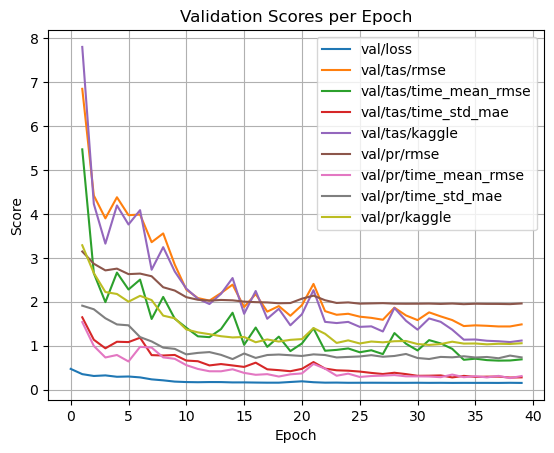

In [9]:
import matplotlib.pyplot as plt
df = pd.read_csv("val_scores.csv")

for col in df.columns[1:]:  # skip epoch column
    plt.plot(df["epoch"], df[col], label=col)

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Scores per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Test model

**IMPORTANT:** Please note that the test metrics will be bad because the test targets have been corrupted on the public Kaggle dataset.
The purpose of testing below is to generate the Kaggle submission file based on your model's predictions, which you can submit to the competition.

In [10]:
trainer.test(lightning_module, datamodule=datamodule)

/home/ccommans/.local/lib/python3.11/site-packages/zarr/core/group.py:3301: UserWarning: Object at .DS_Store is not recognized as a component of a Zarr hierarchy.
  warnings.warn(


Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=290.7992, Time-Mean RMSE=290.7551, Time-Stddev MAE=3.6173
[TEST] pr: RMSE=4.2283, Time-Mean RMSE=3.7488, Time-Stddev MAE=1.3881
✅ Submission saved to: submissions/kaggle_submission_20250614_032256.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/pr/kaggle       │    5.2127299308776855     │
│       test/pr/rmse        │    4.2282586097717285     │
│  test/pr/time_mean_rmse   │    3.7488420009613037     │
│   test/pr/time_std_mae    │    1.3880829811096191     │
│      test/tas/kaggle      │     323.4522705078125     │
│       test/tas/rmse       │     290.7991638183594     │
│  test/tas/time_mean_rmse  │    290.75506591796875     │
│   test/tas/time_std_mae   │     3.617288112640381     │
└───────────────────────────┴───────────────────────────┘

[{'test/tas/rmse': 290.7991638183594,
  'test/tas/time_mean_rmse': 290.75506591796875,
  'test/tas/time_std_mae': 3.617288112640381,
  'test/tas/kaggle': 323.4522705078125,
  'test/pr/rmse': 4.2282586097717285,
  'test/pr/time_mean_rmse': 3.7488420009613037,
  'test/pr/time_std_mae': 1.3880829811096191,
  'test/pr/kaggle': 5.2127299308776855}]

### Plotting Utils


In [11]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


### 🖼️ Visualizing Validation Predictions

This cell loads saved validation predictions and compares them to the ground truth using spatial plots. These visualizations help you qualitatively assess your model's performance.

For each output variable (`tas`, `pr`), we visualize:

- **📈 Time-Mean Map**: The 10-year average spatial pattern for both prediction and ground truth. Helps identify long-term biases or spatial shifts.
- **📊 Time-Stddev Map**: Shows the standard deviation across time for each grid cell — useful for assessing how well the model captures **temporal variability** at each location.
- **🕓 Random Timestep Sample**: Visual comparison of prediction vs ground truth for a single month. Useful for spotting fine-grained anomalies or errors in specific months.

> These plots provide intuition beyond metrics and are useful for debugging spatial or temporal model failures.


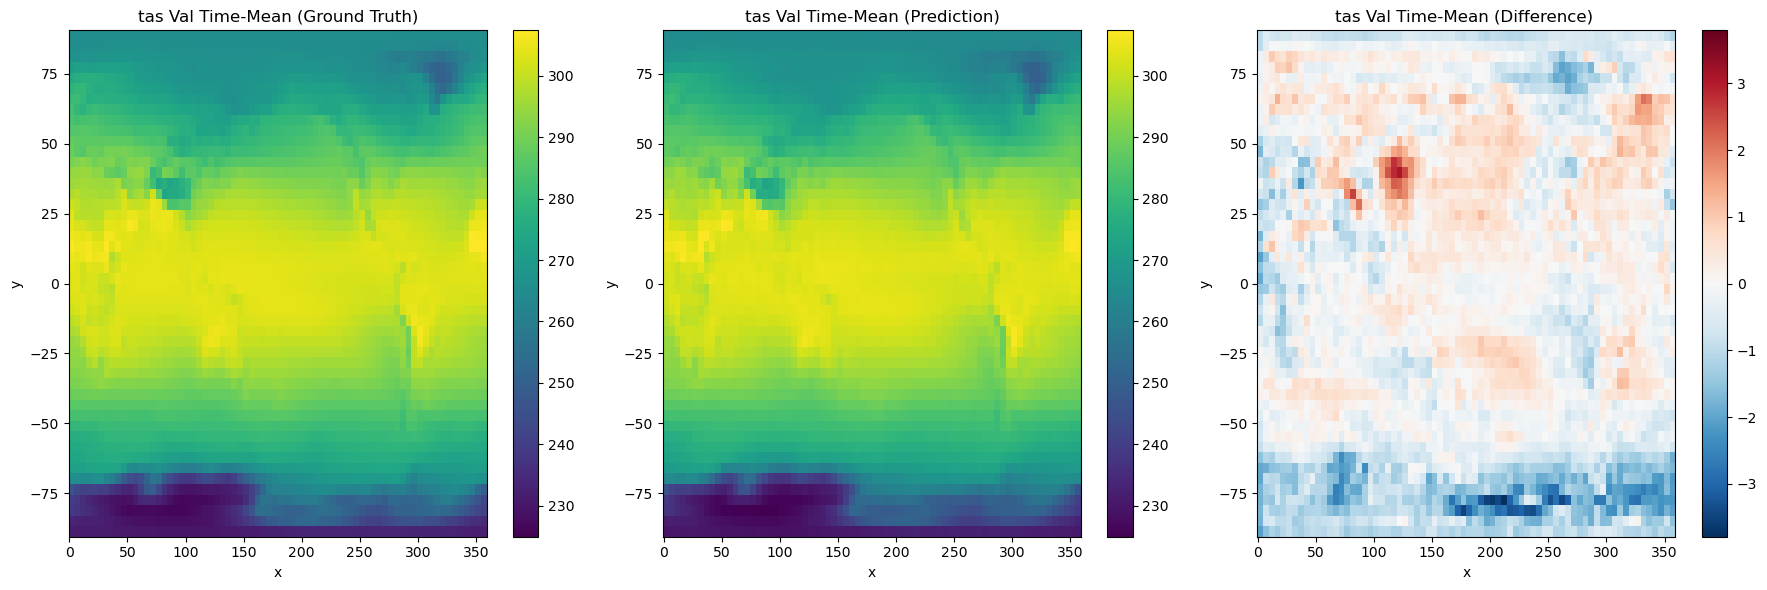

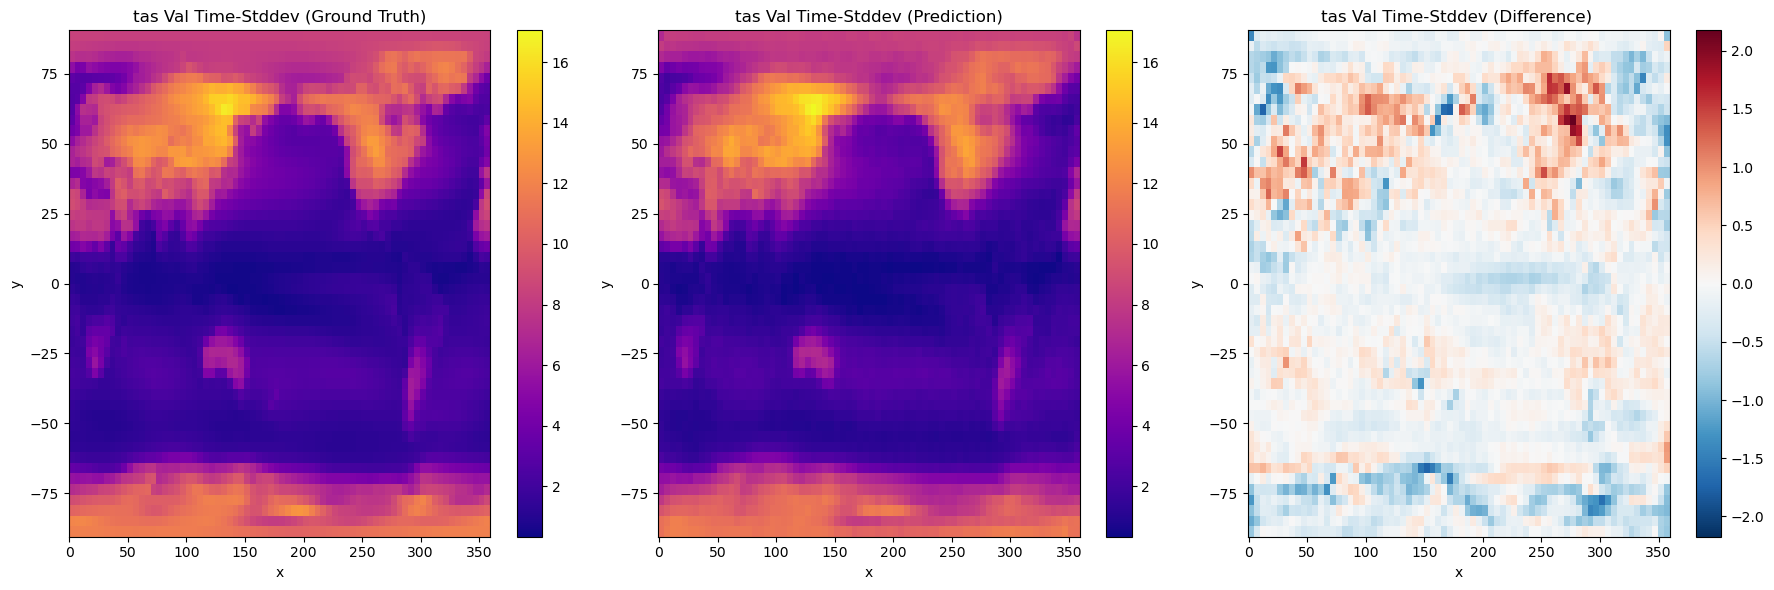

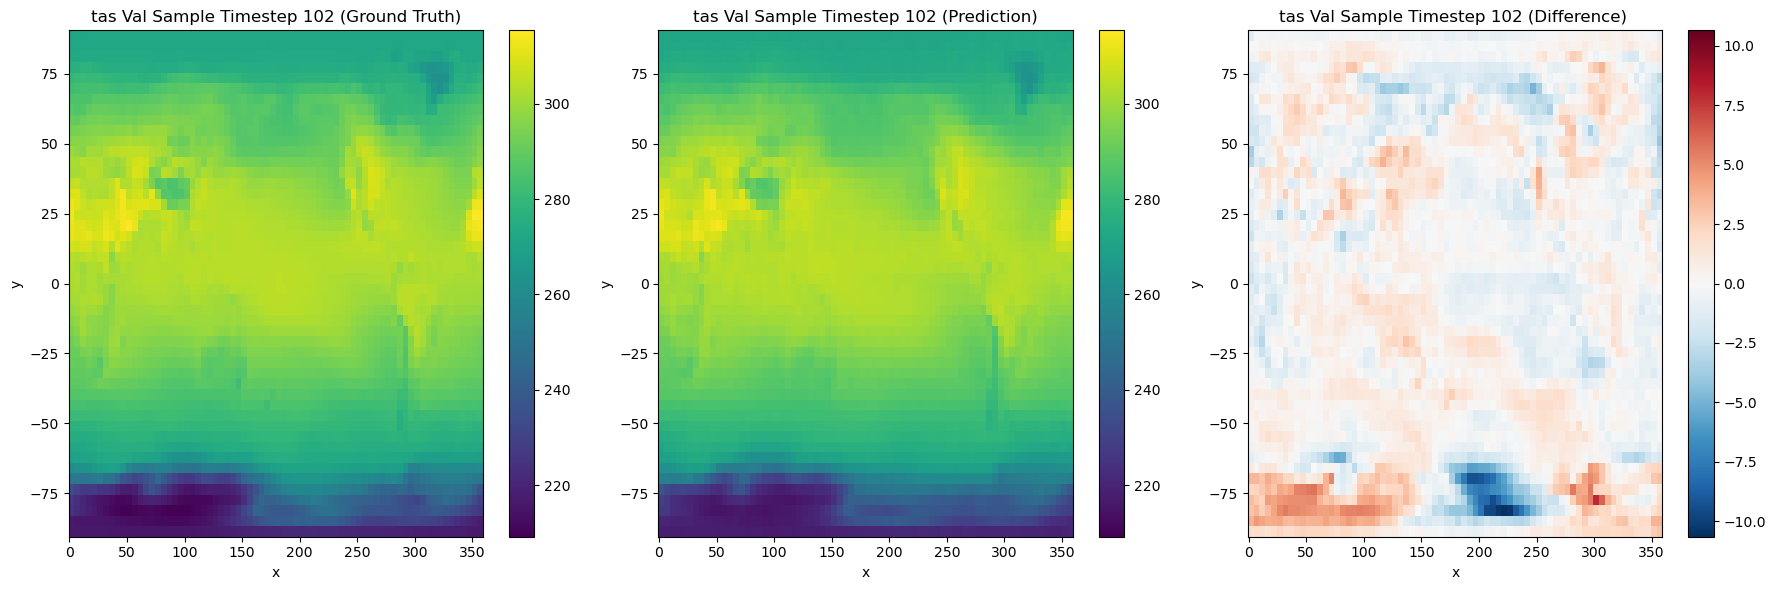

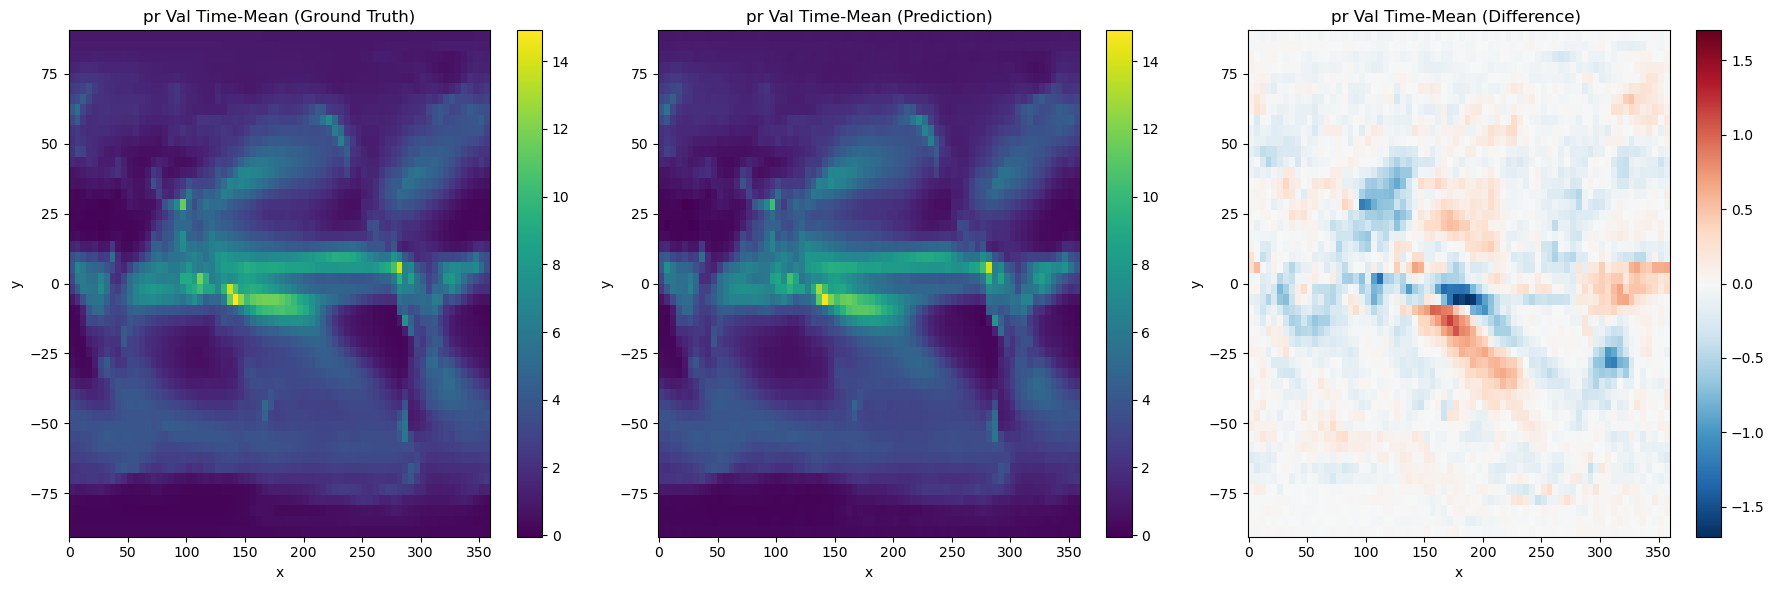

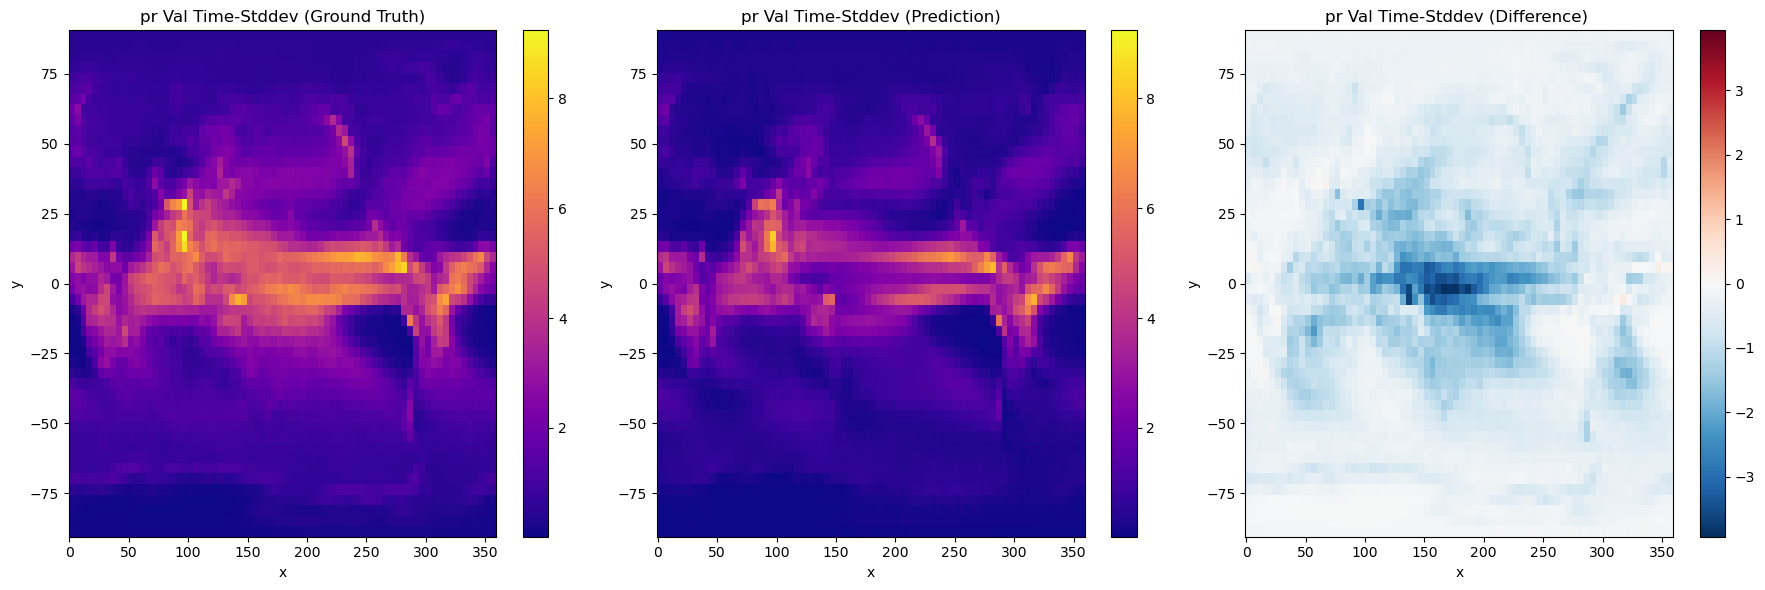

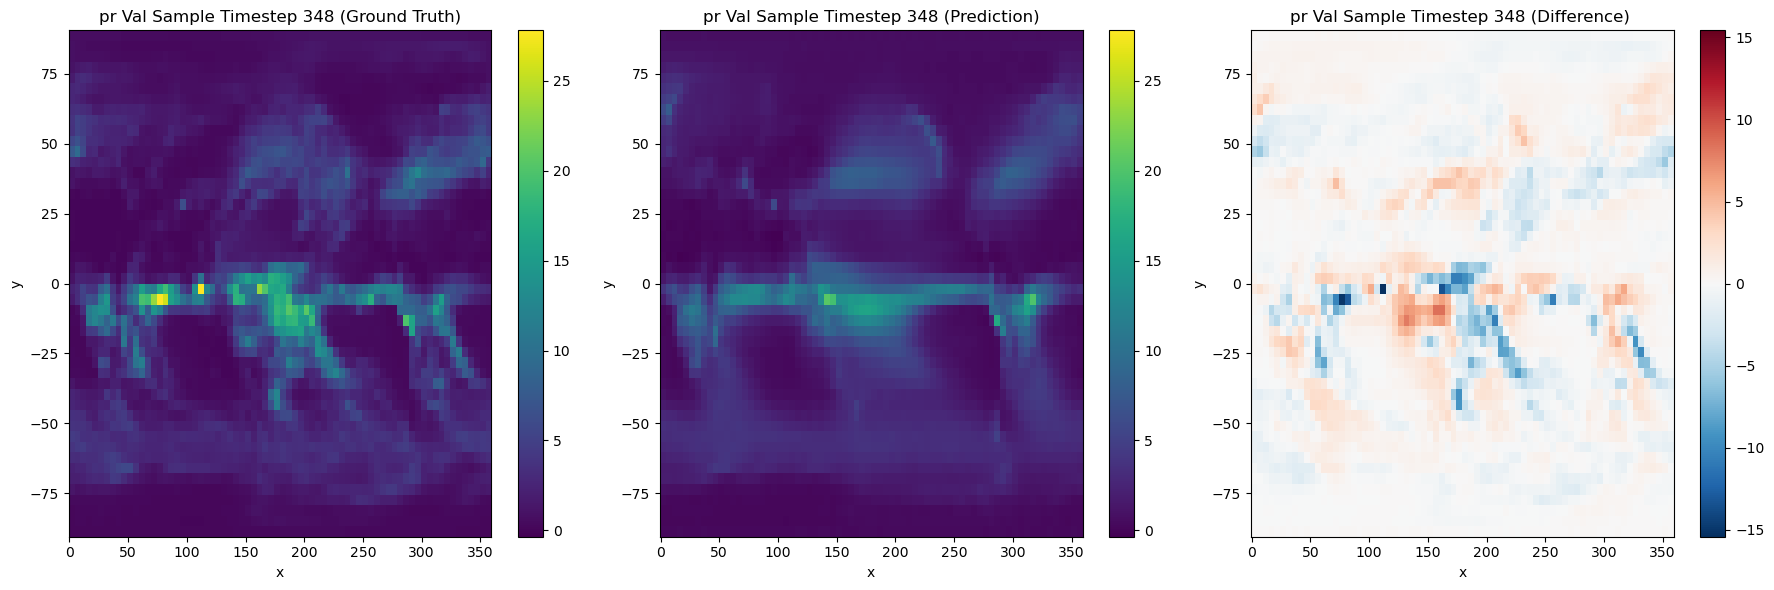

In [12]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = datamodule.get_coords()
output_vars = datamodule.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")


## 🧪 Final Notes

This notebook is meant to serve as a **baseline template** — a starting point to help you get up and running quickly with the climate emulation challenge.

You are **not** required to stick to this exact setup. In fact, we **encourage** you to:

- 🔁 Build on top of the provided `DataModule`.
- 🧠 Use your own model architectures or training pipelines that you’re more comfortable with
- ⚗️ Experiment with ideas  
- 🥇 Compete creatively to climb the Kaggle leaderboard  
- 🙌 Most importantly: **have fun** and **learn as much as you can** along the way

This challenge simulates a real-world scientific problem, and there’s no single "correct" approach — so be curious, experiment boldly, and make it your own!
